# Polynomial Linear Regression

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/linear_regression/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

To get started, we look at a simple linear regression example with `cofi`.

We have a set of noisy data values, Y, measured at known locations, X, and wish to find the best fit degree 3 polynomial.

The function we are going to fit is: $y=-6-5x+2x^2+x^3$

## Table of contents
- [Introduction](#introduction)
- Step 0 - [Import modules](#import)
- Step 1 - [Define the problem](#problem)
- Step 2 - [Define the inversion options](#options)
- Step 3 - [Run the inversion](#inversion)
- Step 4 - [Check out the result](#result)
- Summary - [a clean version of code above](#review)
- Next -   [switching to a different inversion approach](#switch)


## Introduction <a name="introduction"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines three things: 1) the forward problem; 2) the inversion parameter (model) space; and 3) the objective function to be optimised
- `InversionOptions` describes details about how one wants to run the inversion, including the
  inversion approach, backend tool and solver-specific parameters.
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
For each of the above components, there's a `summary()` method to check the current status.
  
So a common workflow includes 4 steps:

1. define `BaseProblem`. This can be done:

    - either: through a series of set functions
      ```
      inv_problem = BaseProblem()
      inv_problem.set_objective(some_function_here)
      inv_problem.set_initial_model(a_starting_point)
      ```

    - or: by subclassing `BaseProblem`
      ```
      class MyOwnProblem(BaseProblem):
          def __init__(self, initial_model, whatever_I_want_to_pass_in):
              self.initial_model = initial_model
              self.whatever_I_want_to_pass_in = whatever_I_want_to_pass_in
          def objective(self, model):
              return some_objective_function_value
      ```
  
2. define `InversionOptions`. Some useful methods include:

    - `set_solving_method()` and `suggest_tools()`. Once you've set a solving method (from "least squares"
      and "optimisation", more will be supported), you can use `suggest_tools()` to see a list of backend tools
      to choose from.
      
3. start an `Inversion`. This step is common:

   ```
   inv = Inversion(inv_problem, inv_options)
   result = inv.run()
   ```
   
4. analyse the result, workflow and redo your experiments with different `InversionOptions`

---
## 0. Import modules <a name="import"></a>

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

---
## 1. Define the problem <a name="problem"></a>

A list of functions/properties that can be set to `BaseProblem` so far:

- `set_objective()`
- `set_gradient()`
- `set_hessian()`
- `set_hessian_times_vector()`
- `set_residual()`
- `set_jacobian()`
- `set_jacobian_times_vector()`
- `set_data_misfit()`
- `set_regularisation()`
- `set_dataset()`
- `set_dataset_from_file()`
- `set_initial_model()`
- `set_model_shape()`
- `set_bounds`
- `set_constraints`
- `name` (only useful when displaying this problem, no functional use)

Other useful functions:

- `defined_components()` (review what have been set)
- `summary()` (better displayed information)
- `suggest_solvers()`

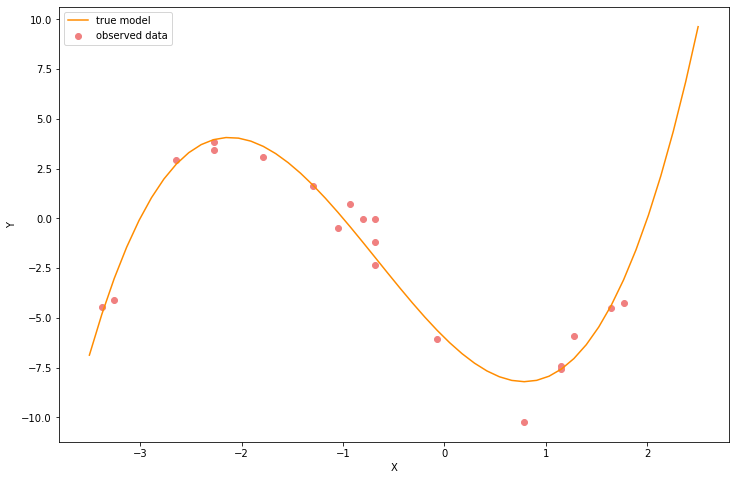

In [3]:
# generate data with random Gaussian noise
basis_func = lambda x: np.array([x**i for i in range(4)]).T               # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m

sample_size = 20                                                          # N
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
forward_func = lambda m: basis_func(x) @ m                                # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0,1,sample_size)    # d

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

In [4]:
# define the problem
inv_problem = BaseProblem()
inv_problem.name = "Polynomial Regression"
inv_problem.set_dataset(x, y_observed)
inv_problem.set_forward(forward_func)
inv_problem.set_jacobian(basis_func(x))

inv_problem.summary()

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['jacobian', 'forward', 'dataset']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['residual', 'jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'regularisation', 'initial_model', 'model_shape', 'bounds', 'constraints']


---
## 2. Define the inversion options <a name="options"></a>

In [5]:
inv_options = InversionOptions()
inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize (by default)` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [6]:
inv_options.suggest_tools()

Here's a complete list of inversion solvers supported by CoFI (grouped by methods):
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [
        "scipy.linalg.lstsq"
    ]
}


In [7]:
inv_options.set_solving_method("linear least square")
inv_options.summary()

Summary for inversion options
Solving method: linear least square
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.linalg.lstsq (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


---

As the "summary" suggested, you've set the solving method, so you can skip the step of
setting a backend tool because there's a default one.

If there are more backend tool options, then use the following function to see available
options and set your desired backend solver.

In [8]:
inv_options.suggest_tools()

Based on the solving method you've set, the following tools are suggested:
['scipy.linalg.lstsq']

Use `InversionOptions.set_tool(tool_name)` to set a specific tool from above
Use `InversionOptions.set_solving_method(method_name)` to change solving method
Use `InversionOptions.unset_solving_method()` if you'd like to see more options
Check CoFI documentation 'Advanced Usage' section for how to plug in your own solver


In [9]:
inv_options.set_tool("scipy.linalg.lstsq")
inv_options.summary()

Summary for inversion options
Solving method: linear least square
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.linalg.lstsq` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


---
## 3. Start an inversion <a name="inversion"></a>

In [10]:
inv = Inversion(inv_problem, inv_options)
inv.summary()

Summary for Inversion
Inversion hasn't started, try `inversion.run()` to see result
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: linear least square
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `scipy.linalg.lstsq` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: Polynomial Regression
Model shape: Unknown
List of functions/properties set by you:
['jacobian', 'for

In [11]:
inv_result = inv.run()
inv_result.success

True

In [12]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
sum of squared residuals: 14.961507878871274
effective rank: 4
singular values: [61.36381472  8.31821387  4.03376312  1.96325721]


---
## 4. Check back your problem setting, inversion setting & result <a name="result"></a>

In [13]:
inv.summary()

Summary for Inversion
Completed with the following result:

Summary for inversion result
SUCCESS
model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
sum of squared residuals: 14.961507878871274
effective rank: 4
singular values: [61.36381472  8.31821387  4.03376312  1.96325721]
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: linear least square
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `scipy.linalg.lstsq` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.
-------------

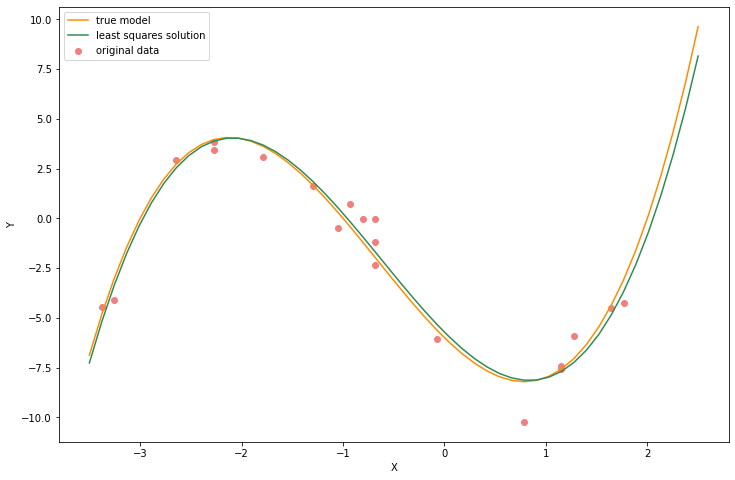

In [14]:
y_synthetic = inv_problem.forward(inv_result.model)

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
_y_synth = _G_plot @ inv_result.model
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.plot(_x_plot, _y_synth, color="seagreen", label="least squares solution")
plt.scatter(x, y_observed, color="lightcoral", label="original data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

Here we see the least squares solver (green curve) fits all of the data well and is a close approximation of the true curve (orange).

---
## 5. Summary: a cleaner version of the above example <a name="review"></a>

For review purpose, here are the minimal set of commands we've used to produce the above result:

In [15]:
######## Import and set random seed
import numpy as np
from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

######## Write code for your forward problem
_m_true = np.array([-6,-5,2,1])                                            # m
_sample_size = 20                                                          # N
x = np.random.choice(np.linspace(-3.5,2.5), size=_sample_size)             # x
basis_func = lambda x: np.array([x**i for i in range(4)]).T               # x -> G
forward_func = lambda m: (np.array([x**i for i in range(4)]).T) @ m        # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0,1,_sample_size)    # d

######## Attach above information to a `BaseProblem`
inv_problem = BaseProblem()
inv_problem.name = "Polynomial Regression"
inv_problem.set_dataset(x, y_observed)
inv_problem.set_jacobian(basis_func(x))

######## Specify how you'd like the inversion to run (via an `InversionOptions`)
inv_options = InversionOptions()
inv_options.set_tool("scipy.linalg.lstsq")

######## Pass `BaseProblem` and `InversionOptions` into `Inversion` and run
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

######## Now check out the result
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [-5.71964359 -5.10903808  1.82553662  0.97472374]

Summary for inversion result
SUCCESS
----------------------------
model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
sum of squared residuals: 14.961507878871274
effective rank: 4
singular values: [61.36381472  8.31821387  4.03376312  1.96325721]


---
## 6. Switching to a different inversion approach <a name="switching"></a>
Alternatively, you can switch to a different inversion solver easily. Here we use a plain optimizer 
`scipy.optimize.minimize` to demonstrate this ability.

For this backend solver to run successfully, some additional information should be provided, otherwise
we will raise an error to notify what additional information is required by the solver.

There are different ways of defining information -
Here in the code below, after we make clear how to calculate the data misfit and regularisation, the 
objective function is generated for you based on the forward function and dataset. Alternatively, you 
can pass in an objective function directly using `inv_problem.set_objective(your_objective_func)`

In [16]:
######## Provide additional information
inv_problem.set_initial_model(np.ones(4))
inv_problem.set_forward(forward_func)
inv_problem.set_data_misfit("L2")
inv_problem.set_regularisation(2, 0.02)

######## Set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")

######## Run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## Check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-5.41196939 -4.9392561   1.67801234  0.92007733]

Summary for inversion result
SUCCESS
----------------------------
fun: 0.3485922162933749
jac: [-1.15483999e-07  4.09781933e-08 -4.24683094e-07  1.17719173e-06]
hess_inv: [[16.02540421  5.1021374  -6.66567291 -2.10949984]
 [ 5.1021374   7.20953772 -2.8775115  -1.53996445]
 [-6.66567291 -2.8775115   4.26430922  1.42538387]
 [-2.10949984 -1.53996445  1.42538387  0.56978587]]
nfev: 135
njev: 27
status: 0
message: Optimization terminated successfully.
nit: 26
model: [-5.41196939 -4.9392561   1.67801234  0.92007733]


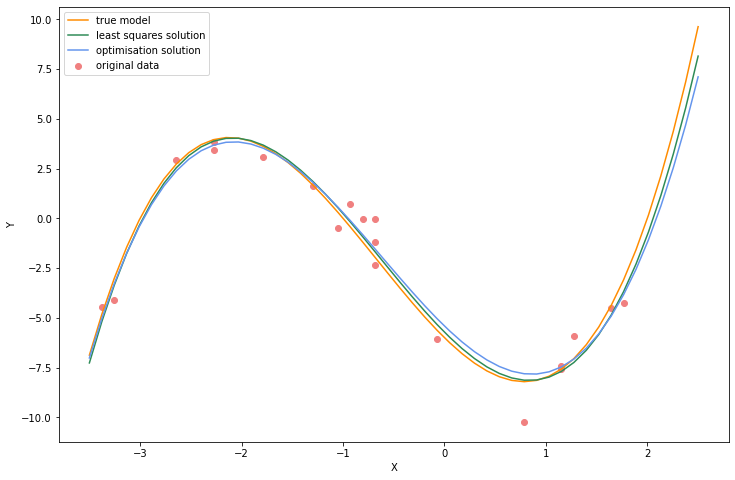

In [17]:
######## Plot all together
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
_y_synth = _G_plot @ inv_result.model
_y_synth_2 = _G_plot @ inv_result_2.model
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.plot(_x_plot, _y_synth, color="seagreen", label="least squares solution")
plt.plot(_x_plot, _y_synth_2, color="cornflowerblue", label="optimisation solution")
plt.scatter(x, y_observed, color="lightcoral", label="original data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

Here we see the  (blue curve) is also a relatively good approximation of the true curve (orange).